# (30) fit — iterative pvae

**Motivation**: host = ```mach```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 2
device = f'cuda:{device_idx}'

## Fit one model

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'jac|deconv')

cfg_vae['n_latents'] = 128
cfg_vae['init_scale'] = 1e-2
cfg_vae['seq_len'] = 5

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 200
cfg_tr['batch_size'] = 120
cfg_tr['kl_beta'] = 3.0

### Make model + trainer

In [4]:
vae = HIPVAE(CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
print(tr.n_iters)

100000

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    HIPVAE   |  559.5 K   |
|     ———     |    ———     |
|  layers.L_0 |  559.5 K   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_t-5_z-[128]_k-32_<jac|deconv>
mc_b120-ep200-lr(0.002)_beta(3:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_02,01:03)

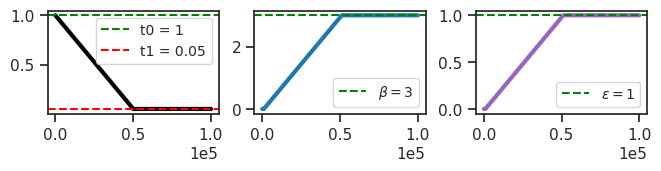

In [6]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [7]:
print_num_params(vae.input_layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  559.5 K   |
|     ———      |    ———     |
|    fc_dec    |  262.1 K   |
|     dec      |  297.1 K   |
+--------------+------------+

In [8]:
print(vae.input_layer.dec)

Sequential(
  (0): UnFlatten()
  (1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): SiLU(inplace=True)
  (3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (4): SiLU(inplace=True)
  (5): ConvTranspose2d(32, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
  (6): SiLU(inplace=True)
  (7): ConvTranspose2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)

### Fit model

In [10]:
tr.train(fit_name = f"DeConv_{tr.cfg.name()}")

epoch # 200, avg loss: 22.597405: 100%|██████████████████████████████████████████████████████| 200/200 [17:04:33<00:00, 307.37s/it]


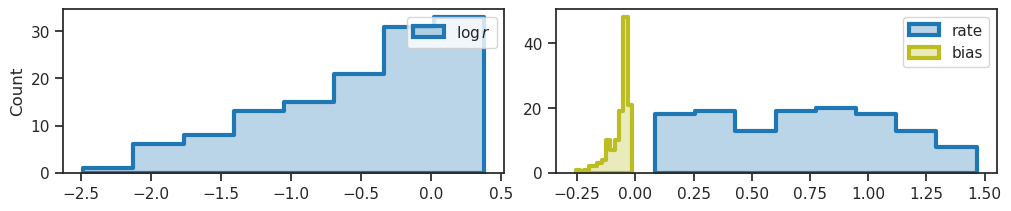

In [11]:
log_rate = tonp(tr.model.input_layer.log_rate).ravel()
bias = tonp(tr.model.input_layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=3, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [12]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
print(loss)

{
    'kl': array([9.1686   , 6.009139 , 2.7175658, 1.6314745, 1.2107679],
      dtype=float32),
    'recon': array([36.46504 , 19.90584 , 14.512387, 12.367527, 11.213454],
      dtype=float32),
    'nelbo': array([45.63362 , 25.915104, 17.229963, 13.998989, 12.42422 ],
      dtype=float32)
}

### Loss

In [13]:
results = tr.analysis(2000, verbose=True)

100%|██████████████████████████████| 84/84 [3:07:54<00:00, 134.21s/it]


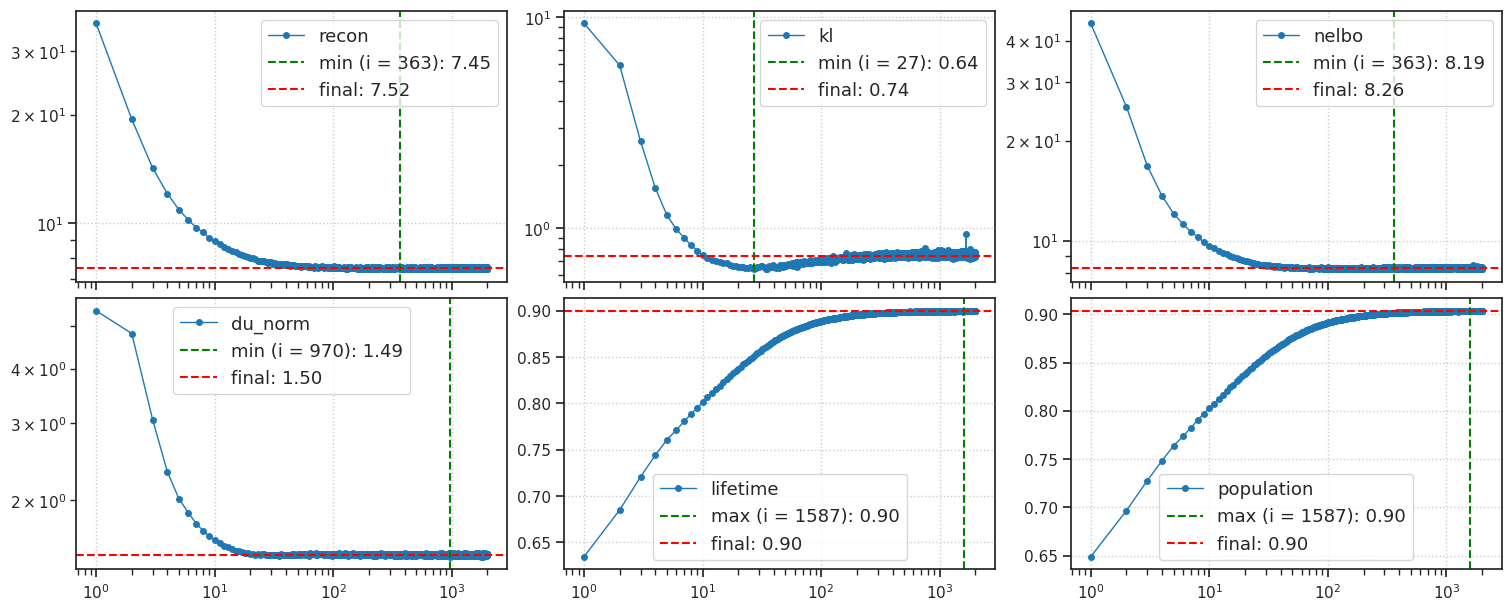

In [14]:
from figures.analysis import plot_convergence
plot_convergence(results)

## Older results

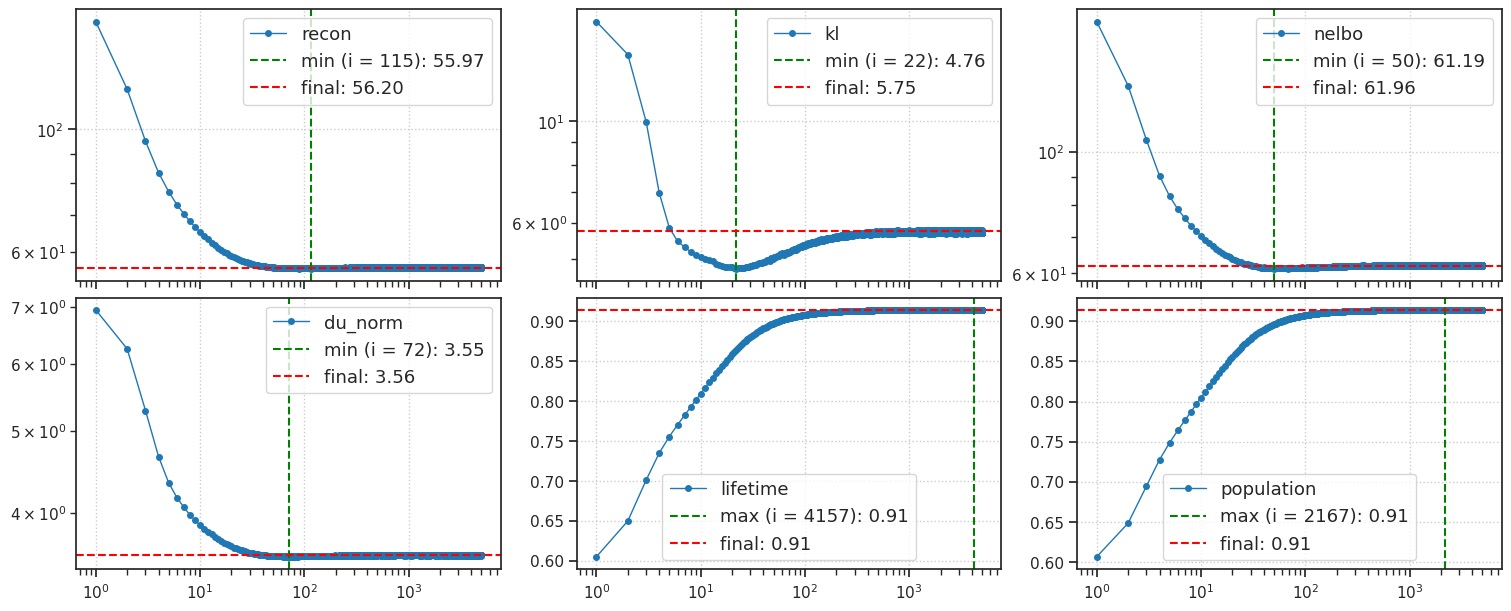

In [14]:
## Was: T = 3, beta = 3.0

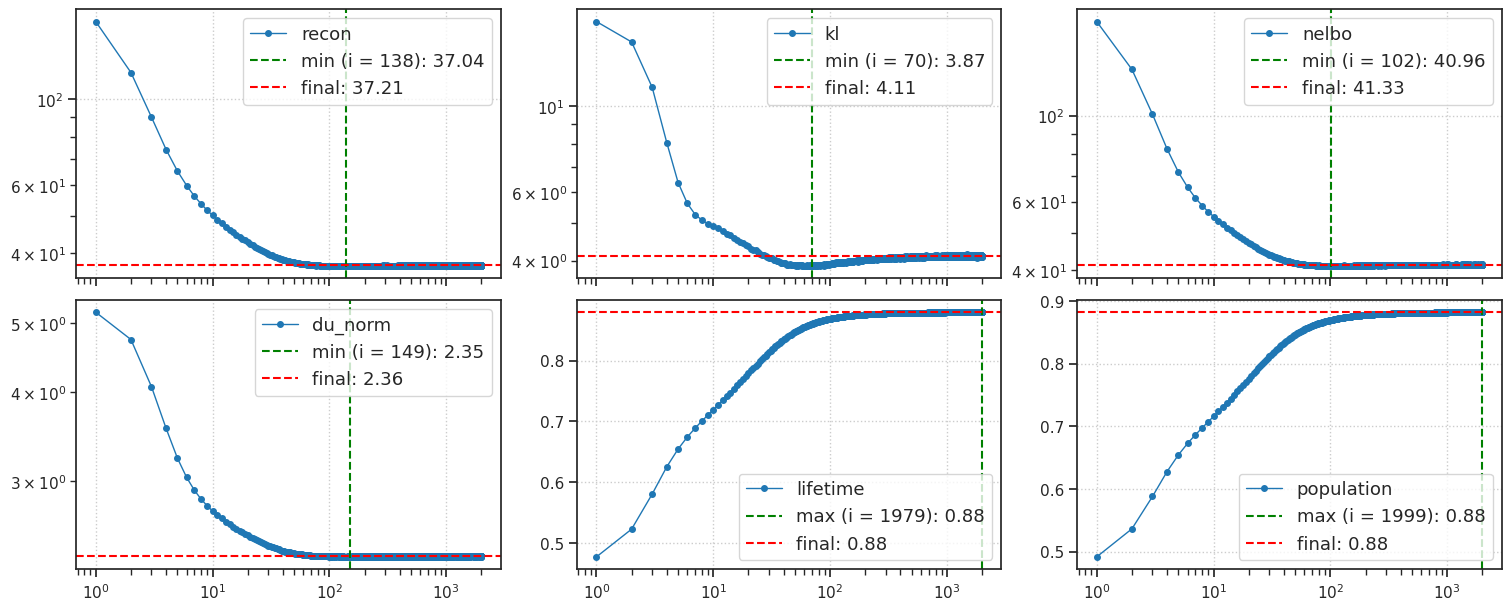

In [13]:
## Was w/ gain

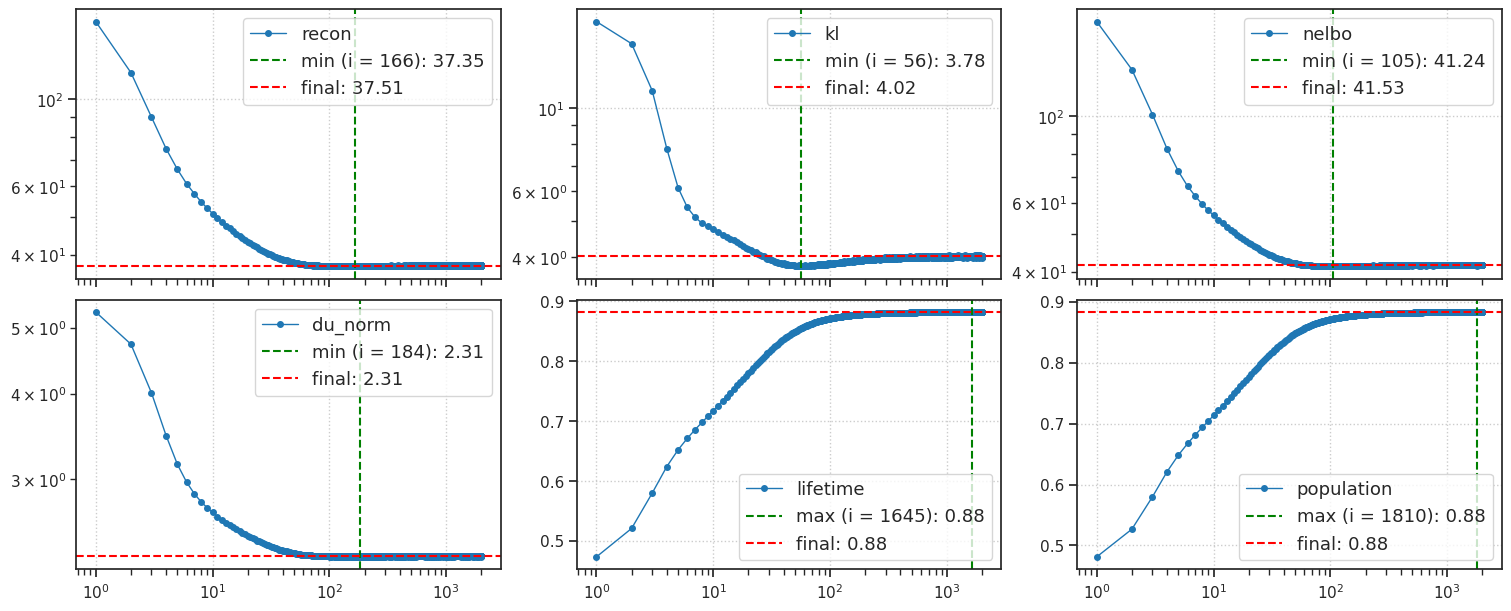

In [15]:
## Was bias only